# Исследование данных о продажах игр для интернет-магазина «Стримчик»

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

# Целью исследования являются ответы на вопросы:

1. Составление портрета пользователя по регионам (NA, EU, JP), подготовить топ-5 самых популярных платформ, самых популярных жанров. Определение влияния рейтинга ESRB на продажи в отдельном регионе?
2. Проверка гипотез: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые? Средние пользовательские рейтинги жанров Action и Sports разные.

# Ход исследования
Данные получены из файла csv games.csv
Исследование произойдет в 6 этапов:

Шаг 1. Откройте файл с данными и изучите общую информацию

Шаг 2. Подготовьте данные

Шаг 3. Проведите исследовательский анализ данных

Шаг 4. Составьте портрет пользователя каждого региона

Шаг 5. Проверьте гипотезы

Шаг 6. Напишите общий вывод

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm
from scipy import stats as st
import scipy.stats as stats

#### Шаг 1. Загрузка данных

##### Загрузка файла games.csv

In [2]:
games = pd.read_csv('/datasets/games.csv',sep=',')
games.info()
games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### Шаг 2. Подготовьте данные

##### Замена названий столбцов

In [3]:
games.columns = games.columns.str.lower()
games.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E


##### Удаление дубликатов

In [4]:
games = games.drop_duplicates()
games['name'] = games['name'].str.lower()
games['platform'] = games['platform'].str.lower()
key_columns = ['name', 'platform', 'year_of_release']
duplicates = games.duplicated(subset=key_columns, keep=False)
games = games[~duplicates]
games.info()
games.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16711 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16711 non-null  object 
 1   platform         16711 non-null  object 
 2   year_of_release  16442 non-null  float64
 3   genre            16711 non-null  object 
 4   na_sales         16711 non-null  float64
 5   eu_sales         16711 non-null  float64
 6   jp_sales         16711 non-null  float64
 7   other_sales      16711 non-null  float64
 8   critic_score     8135 non-null   float64
 9   user_score       10012 non-null  object 
 10  rating           9947 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

Удалил дубликаты, посчитал пропущенные значения по  столбцам. 

##### Столбец year_of_release

In [7]:
games = games.dropna(subset=['year_of_release']) # Удаление строк с пропусками по году релиза
print(games['year_of_release'].isna().sum())
games['year_of_release'] = pd.to_datetime(games['year_of_release'], format='%Y').dt.year #преобразование в год
print(games['year_of_release'].unique())

0
[2006 1985 2008 2009 1996 1989 1984 2005 1999 2007 2010 2013 2004 1990
 1988 2002 2001 2011 1998 2015 2012 2014 1992 1997 1993 1994 1982 2016
 2003 1986 2000 1995 1991 1981 1987 1980 1983]


Удалил строки с пропусками по году релиза, преобразовал столбец в формат даты и оставил год. Вероятной причиной образования пропусков можно считать ошибки заполнения.

##### Столбец critic_score

In [8]:
print(games['critic_score'].unique())
games['critic_score'] = games['critic_score'].fillna(0).astype(int)
print(games['critic_score'].describe())

[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 41. 36. 31.
 27. 35. 26. 19. 28. 23. 24. 21. 17. 13.]
count    16442.000000
mean        33.488383
std         35.819575
min          0.000000
25%          0.000000
50%          0.000000
75%         70.000000
max         98.000000
Name: critic_score, dtype: float64


Заполнил отсутсвующие значения нулем, привел к типу int, нет дробных значений оценки. Вероятной причиной пропусков можно считать программный сбой или отсутсвие оценки критиков. Значений выше 100 нет.

##### Столбец user_score

In [9]:
print(games[games['user_score']=='0'])
print(games['user_score'].unique())
games['user_score'] = games['user_score'].fillna(0)
games['user_score'] = games['user_score'].replace('tbd', '0').astype(float)
games['user_score'].describe()

                                    name platform  year_of_release      genre  \
2835  my little pony: pinkie pie's party       ds             2008  Adventure   

      na_sales  eu_sales  jp_sales  other_sales  critic_score user_score  \
2835      0.66       0.0       0.0         0.06             0          0   

     rating  
2835      E  
['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


count    16442.000000
mean         3.233962
std          3.689182
min          0.000000
25%          0.000000
50%          0.000000
75%          7.300000
max          9.700000
Name: user_score, dtype: float64

Заполнил отсутсвующие значения нулем, привел тип к float. Из открытых источников аббревиатура  tbd (to be discussed) означает, что данные не определны, в данном случае, что оценка еще не сформирована. Для дальнейшей работы целесообразно заменить tbd на отсутсвующую оценку 0. Вероятной причиной пропусков можно считать программный сбой или отсутсвие оценок пользователей. Значений выше 10 нет.

##### Столбец rating

In [10]:
print(games['rating'].unique())
games['rating'] = games['rating'].fillna('non_esrb')
games[games['rating'].isna()]

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Пропуски не заполнял, вероятной присиной отсуствия оценки может быть отсутсвие проверки состороны организации ESRB, так же данная организацияоснована в 1994 году, а часть игр в данных произведены ранее.

##### Добавление столбца total_sales

In [11]:
games['total_sales'] = games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
games.info()
games.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16442 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16442 non-null  object 
 1   platform         16442 non-null  object 
 2   year_of_release  16442 non-null  int64  
 3   genre            16442 non-null  object 
 4   na_sales         16442 non-null  float64
 5   eu_sales         16442 non-null  float64
 6   jp_sales         16442 non-null  float64
 7   other_sales      16442 non-null  float64
 8   critic_score     16442 non-null  int64  
 9   user_score       16442 non-null  float64
 10  rating           16442 non-null  object 
 11  total_sales      16442 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
total_sales        0
dtype: int64

Добавление столбца total_sales с суммой продаж по регионам. Просмотр получившейся таблицы на пропуски.

##### Вывод по результатам выполнения предобработки данных

Там, где могли, мы заменили пропущенные значения (столбец 'year of release'). Что касается остальных пропусков, для их заполнения у нас недостаточно данных.

#### Шаг 3. Проведите исследовательский анализ данных

##### Сколько игр выпускалось в разные годы

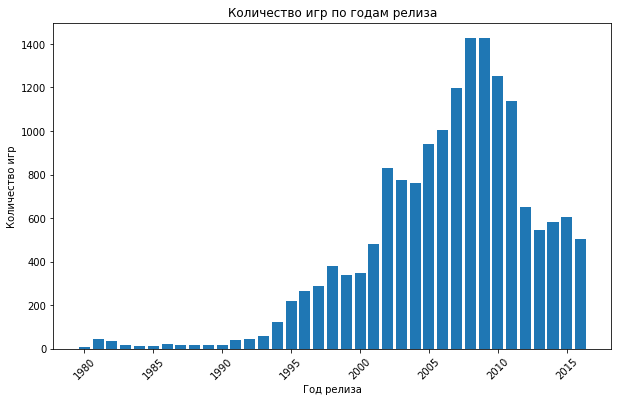

In [12]:
games_years = games['year_of_release'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(games_years.index, games_years.values)
plt.xlabel('Год релиза')
plt.ylabel('Количество игр')
plt.title('Количество игр по годам релиза')
plt.xticks(rotation=45)
plt.show()

Данные до 1995 года можно считать незначительными по количеству релизов игр.

##### Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам

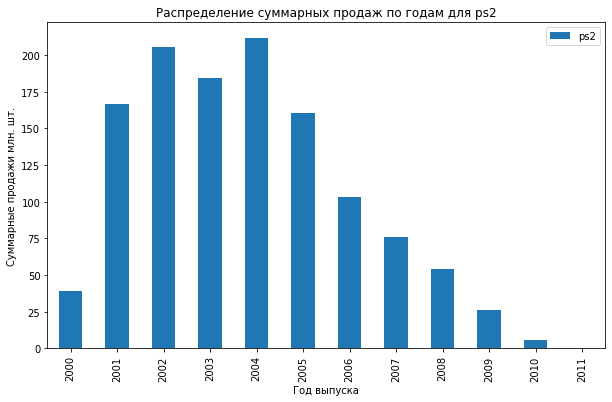

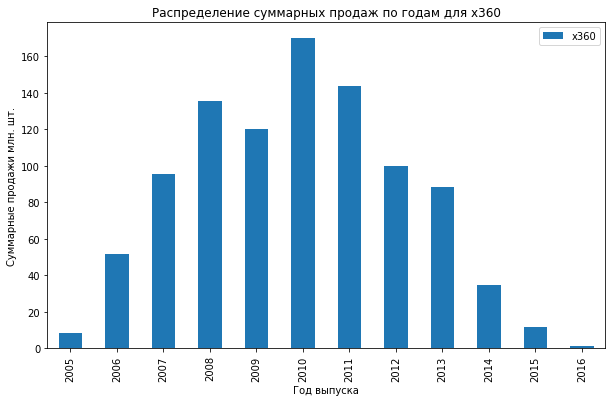

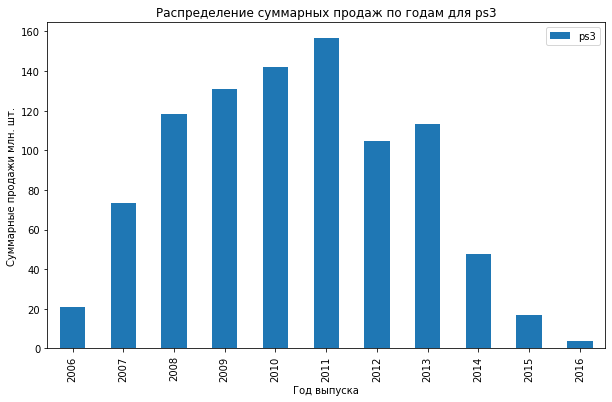

In [13]:
platform_sales = games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
top_platforms = platform_sales.head(3).index
for platform in top_platforms:
    plt.figure(figsize=(10, 6))
    platform_data = games[games['platform'] == platform]
    platform_data.groupby('year_of_release')['total_sales'].sum().plot(kind='bar', label=platform)
    plt.xlabel('Год выпуска')
    plt.ylabel('Суммарные продажи млн. шт.')
    plt.title(f'Распределение суммарных продаж по годам для {platform}')
    plt.legend()
    plt.show()

Характерный срок появления и исчезновения платформ 10 лет, пик продаж игр для платформы наступает около 5 лет существования на рынке. В связи с динамичными изменениями в отрасли для постоения дальнейшего прогноза необходимо использовать данные за период около 3 лет.

##### Возьмите данные за соответствующий актуальный период

In [14]:
actual_games = games[games['year_of_release'] > 2013]
actual_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     1689 non-null   int64  
 9   user_score       1689 non-null   float64
 10  rating           1689 non-null   object 
 11  total_sales      1689 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 171.5+ KB


##### Выберите несколько потенциально прибыльных платформ.

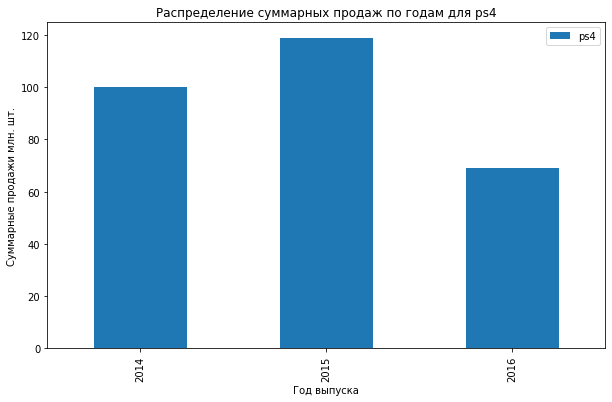

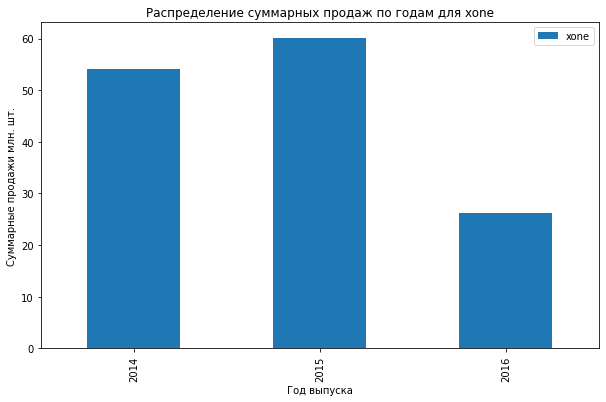

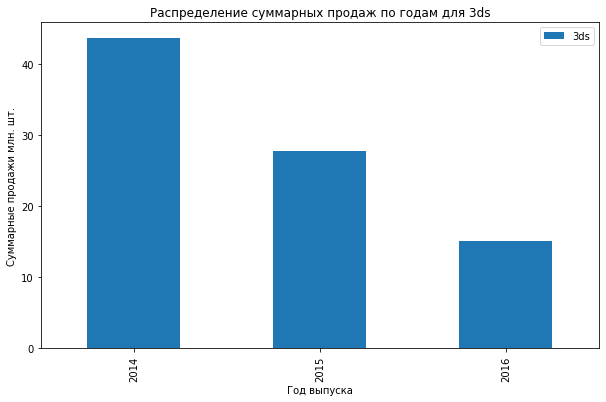

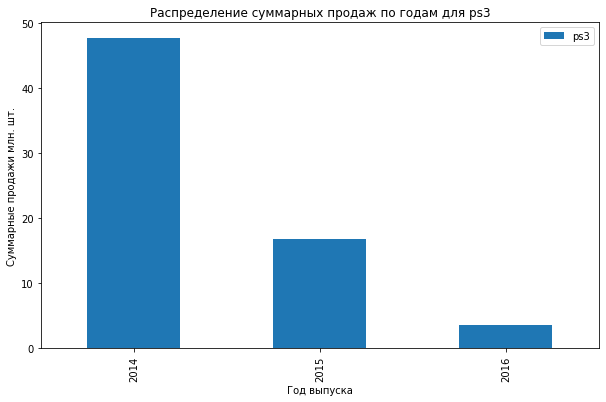

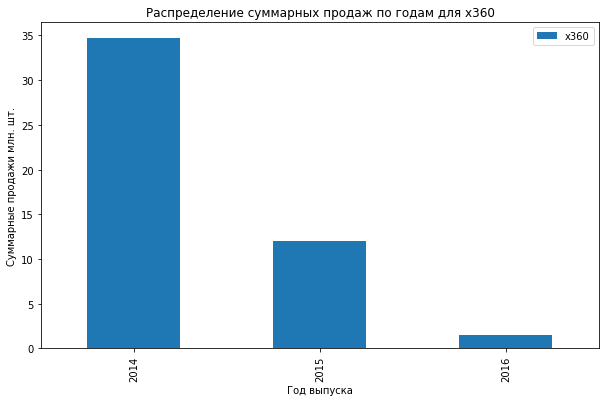

In [15]:
actual_platform_sales = actual_games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
actual_top_platforms = actual_platform_sales.head(5).index
for platform in actual_top_platforms:
    plt.figure(figsize=(10, 6))
    platform_data = actual_games[actual_games['platform'] == platform]
    platform_data.groupby('year_of_release')['total_sales'].sum().plot(kind='bar', label=platform)
    plt.xlabel('Год выпуска')
    plt.ylabel('Суммарные продажи млн. шт.')
    plt.title(f'Распределение суммарных продаж по годам для {platform}')
    plt.legend()
    plt.show()

По графикам видно, что набирают популярность такие платформы как: PS4, XOne, 3DS и PC.

##### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

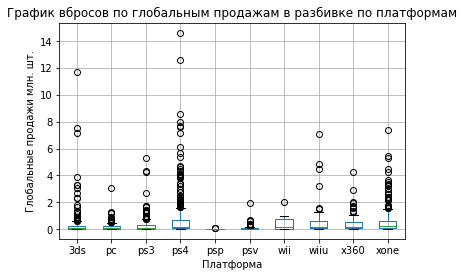

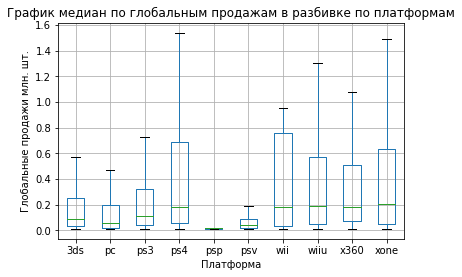

In [16]:
actual_games.boxplot(column='total_sales', by='platform')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи млн. шт.')
plt.title('График вбросов по глобальным продажам в разбивке по платформам')
plt.suptitle('') 
plt.show()
actual_games.boxplot(column='total_sales', by='platform', showfliers=False)
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи млн. шт.')
plt.title('График медиан по глобальным продажам в разбивке по платформам')
plt.suptitle('') 
plt.show()

По графику вбросов заметно, что среди платформ продажи различаются у PS3 был один год с максимальными продажами, а у 3DS 4 года получалось продать от 10 до 15 млн копий. 

По графику медиан заметно, что медианы у каждой платформы совои, что говорит о различном развитии платформ. Так же заметно, что РС заменяют приставками.

##### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.  Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. 

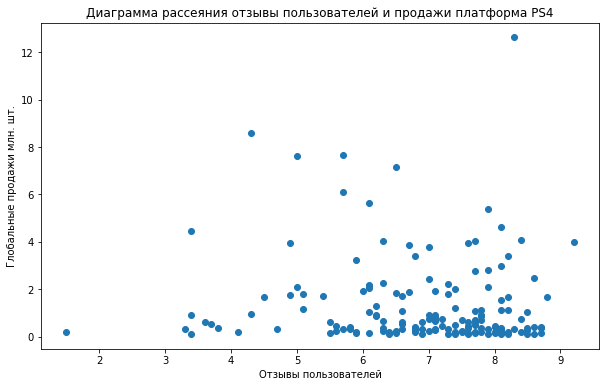

Корреляция отзвов пользователей к продажам PS4: -0.0846046568715454


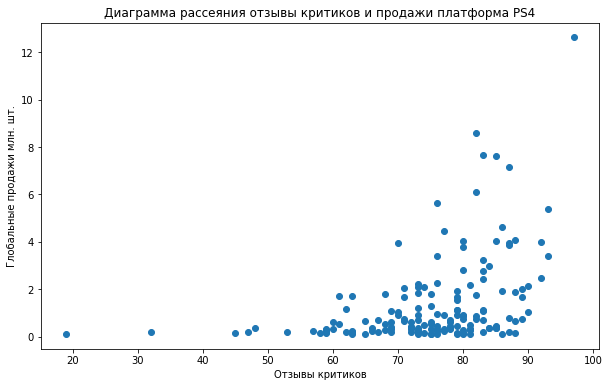

Корреляция отзвов критиков к продажам PS4: 0.39884285489685783


In [17]:
ps4_sales = actual_games[actual_games['platform'] == 'ps4']
ps4_sales = ps4_sales[ps4_sales['user_score']>0]
ps4_sales = ps4_sales[ps4_sales['critic_score']>0]
ps4_sales = ps4_sales[ps4_sales['total_sales']>0.1]
plt.figure(figsize=(10, 6))
plt.scatter(ps4_sales['user_score'], ps4_sales['total_sales'])
plt.xlabel('Отзывы пользователей')
plt.ylabel('Глобальные продажи млн. шт.')
plt.title('Диаграмма рассеяния отзывы пользователей и продажи платформа PS4')
plt.suptitle('') 
plt.show()
correlation_user = ps4_sales['user_score'].corr(ps4_sales['total_sales'])
print("Корреляция отзвов пользователей к продажам PS4:", correlation_user)
plt.figure(figsize=(10, 6))
plt.scatter(ps4_sales['critic_score'], ps4_sales['total_sales'])
plt.xlabel('Отзывы критиков')
plt.ylabel('Глобальные продажи млн. шт.')
plt.title('Диаграмма рассеяния отзывы критиков и продажи платформа PS4')
plt.suptitle('')
plt.show()
correlation_critic = ps4_sales['critic_score'].corr(ps4_sales['total_sales'])
print("Корреляция отзвов критиков к продажам PS4:", correlation_critic)

Корреляция отзвов критиков к продажам умеренная, корреляции отзвов пользователей к продажам не выявлено.

##### Соотнесите выводы с продажами игр на других платформах

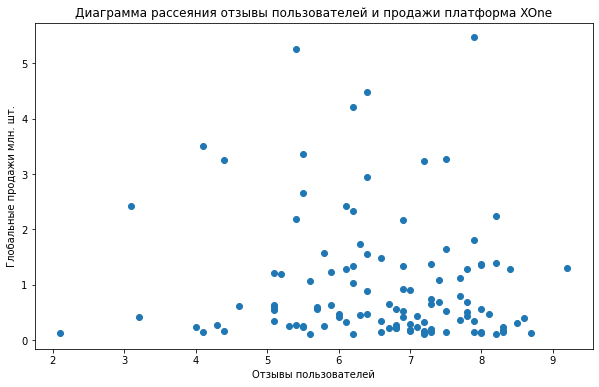

Корреляция отзвов пользователей к продажам XOne: -0.10312160651062723


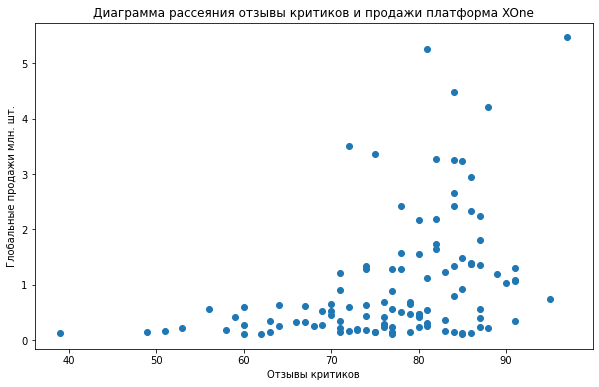

Корреляция отзвов критиков к продажам XOne: 0.40040174832660397


In [18]:
xone_sales = actual_games[actual_games['platform'] == 'xone']
xone_sales = xone_sales[xone_sales['user_score']>0]
xone_sales = xone_sales[xone_sales['critic_score']>0]
xone_sales = xone_sales[xone_sales['total_sales']>0.1]
plt.figure(figsize=(10, 6))
plt.scatter(xone_sales['user_score'], xone_sales['total_sales'])
plt.xlabel('Отзывы пользователей')
plt.ylabel('Глобальные продажи млн. шт.')
plt.title('Диаграмма рассеяния отзывы пользователей и продажи платформа XOne')
plt.suptitle('') 
plt.show()
correlation_user = xone_sales['user_score'].corr(xone_sales['total_sales'])
print("Корреляция отзвов пользователей к продажам XOne:", correlation_user)
plt.figure(figsize=(10, 6))
plt.scatter(xone_sales['critic_score'], xone_sales['total_sales'])
plt.xlabel('Отзывы критиков')
plt.ylabel('Глобальные продажи млн. шт.')
plt.title('Диаграмма рассеяния отзывы критиков и продажи платформа XOne')
plt.suptitle('')
plt.show()
correlation_critic = xone_sales['critic_score'].corr(xone_sales['total_sales'])
print("Корреляция отзвов критиков к продажам XOne:", correlation_critic)

Для проверки выводов была вязта одна из платформ также набирающих популярность XOne, аналогичная тенденция прослеживается и для данной платформы. 

##### Посмотрите на общее распределение игр по жанрам

<Figure size 720x432 with 0 Axes>

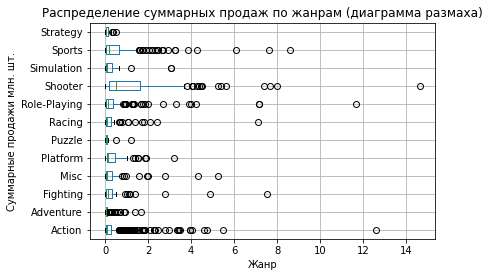

<Figure size 720x432 with 0 Axes>

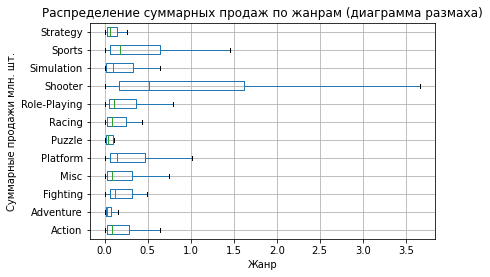

Топ-3 прибыльных жанра: genre
Action     199.36
Shooter    170.94
Sports     109.48
Name: total_sales, dtype: float64
Топ-3 провальных жанра: genre
Simulation    13.13
Strategy       3.96
Puzzle         2.21
Name: total_sales, dtype: float64


In [19]:
genre_sales = actual_games.groupby('genre')['total_sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
actual_games.boxplot(column='total_sales', by='genre', vert=False)
plt.xlabel('Жанр')
plt.ylabel('Суммарные продажи млн. шт.')
plt.title('Распределение суммарных продаж по жанрам (диаграмма размаха)')
plt.suptitle('')
plt.show()
plt.figure(figsize=(10, 6))
actual_games.boxplot(column='total_sales', by='genre',showfliers=False, vert=False)
plt.xlabel('Жанр')
plt.ylabel('Суммарные продажи млн. шт.')
plt.title('Распределение суммарных продаж по жанрам (диаграмма размаха)')
plt.suptitle('')
plt.show()

print("Топ-3 прибыльных жанра:", genre_sales.head(3))
print("Топ-3 провальных жанра:", genre_sales.tail(3))



Изучив диаграмму видно, что самым стабильным по продажам является жанр Shooter, Sports и Platform.

#####  Вывод по результатам исследовательского анализа данных

Данные до 1995 года можно считать незначительными по количеству релизов игр.
для постоения дальнейшего прогноза использовались данные за период 3 года.
У PS4 и XOne наблюдается связь между оценками критиков и продажами. А связь между оценками пользователей и продажами отсутсвует Это может говорит о том, что покупатели прислушиваются к оценкам критиков.


#### Шаг 4. Составьте портрет пользователя каждого региона

##### Определите для пользователя каждого региона (NA, EU, JP) самые популярные платформы (топ-5)

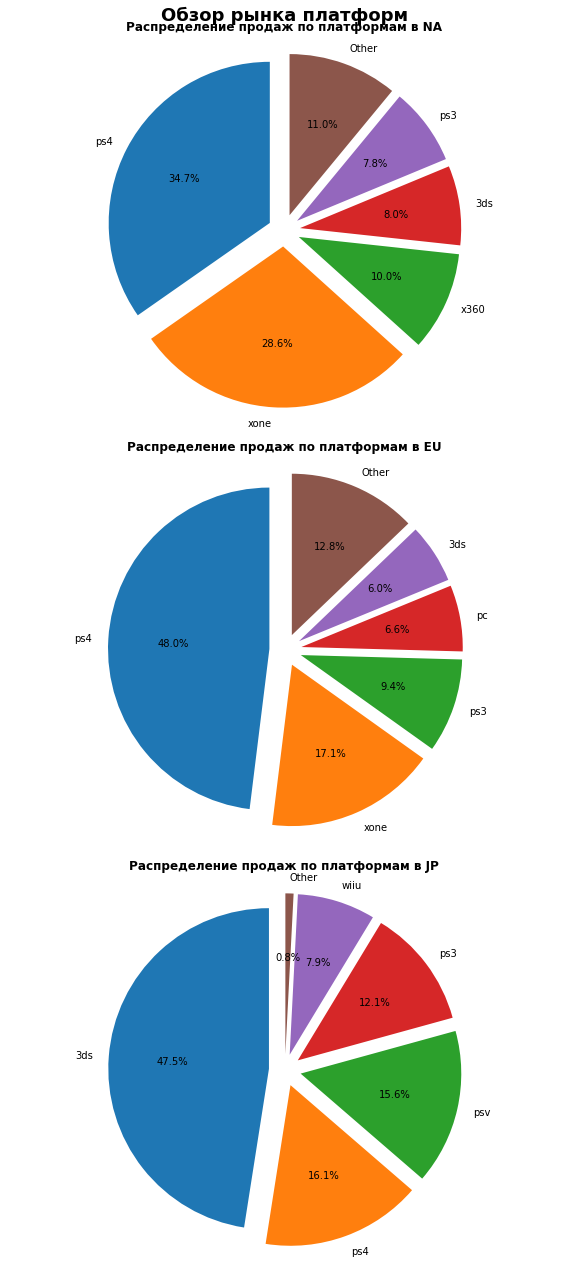

Топ-5 платформ в NA: platform
ps4     98.61
xone    81.27
x360    28.30
3ds     22.64
ps3     22.05
Name: na_sales, dtype: float64
Топ-5 платформ в EU: platform
ps4     130.04
xone     46.25
ps3      25.54
pc       17.97
3ds      16.12
Name: eu_sales, dtype: float64
Топ-5 платформ в JP: platform
3ds     44.24
ps4     15.02
psv     14.54
ps3     11.22
wiiu     7.31
Name: jp_sales, dtype: float64


In [20]:
sales_region = actual_games.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales']].sum()
top_platform_na = sales_region['na_sales'].nlargest(5)
top_platform_eu = sales_region['eu_sales'].nlargest(5)
top_platform_jp = sales_region['jp_sales'].nlargest(5)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18))
for i, region in enumerate(['NA', 'EU', 'JP']):
    if region == 'NA':
        top_platform = top_platform_na
    elif region == 'EU':
        top_platform = top_platform_eu
    else:
        top_platform = top_platform_jp
    labels = top_platform.index.tolist() + ['Other']
    sizes = top_platform.values.tolist() + [sales_region.loc[~sales_region.index.isin(top_platform.index), region.lower() + '_sales'].sum()]
    explode = [0.1] * len(labels) 
    axes[i].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[i].axis('equal')
    axes[i].set_title(f'Распределение продаж по платформам в {region}', fontweight='bold', fontsize=12)
fig.suptitle('Обзор рынка платформ', fontweight='bold', fontsize=18)
plt.tight_layout()
plt.show()
print("Топ-5 платформ в NA:", top_platform_na)
print("Топ-5 платформ в EU:", top_platform_eu)
print("Топ-5 платформ в JP:", top_platform_jp)

Для разных регионов топ платформ выгрядит по разному

##### Определите для пользователя каждого региона (NA, EU, JP) самые популярные жанры (топ-5)

In [21]:
sales_genre = actual_games.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].sum()
top_genre_na = sales_genre['na_sales'].nlargest(5).index.tolist()
top_genre_eu = sales_genre['eu_sales'].nlargest(5).index.tolist()
top_genre_jp = sales_genre['jp_sales'].nlargest(5).index.tolist()
print("Топ-5 жанры в NA:", top_genre_na)
print("Топ-5 жанры в EU:", top_genre_eu)
print("Топ-5 жанры в JP:", top_genre_jp)

Топ-5 жанры в NA: ['Shooter', 'Action', 'Sports', 'Role-Playing', 'Misc']
Топ-5 жанры в EU: ['Action', 'Shooter', 'Sports', 'Role-Playing', 'Racing']
Топ-5 жанры в JP: ['Role-Playing', 'Action', 'Fighting', 'Misc', 'Shooter']


Топ 3 жанров отличаются только в JP регионе.

##### Определите для пользователя каждого региона (NA, EU, JP) влияет ли рейтинг ESRB на продажи в отдельном регионе

In [22]:
sales_esrb = actual_games.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum()
print("Продажи по ESRB в NA:")
print(sales_esrb['na_sales'])
print("\nПродажи по ESRB в EU:")
print(sales_esrb['eu_sales'])
print("\nПродажи по ESRB в JP:")
print(sales_esrb['jp_sales'])

Продажи по ESRB в NA:
rating
E           50.74
E10+        33.23
M           96.42
T           38.95
non_esrb    64.72
Name: na_sales, dtype: float64

Продажи по ESRB в EU:
rating
E           58.06
E10+        26.16
M           93.44
T           34.07
non_esrb    58.95
Name: eu_sales, dtype: float64

Продажи по ESRB в JP:
rating
E            8.94
E10+         4.46
M            8.01
T           14.78
non_esrb    56.90
Name: jp_sales, dtype: float64


Рейтинг ESRB оказывает малое влияние на продажи в различных регионах. Количество проданных игр без оценки ESRB составляет значительную долю от каждого рынка, наиболее значительную часть составляет в региона JP.

#### Шаг 5. Проверьте гипотезы

##### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем гипотезы:

Нулевая гипотеза (H0): Средние пользовательские рейтинги платформ Xbox One и PC равны

Альтернативная гипотеза (H1): Средние пользовательские рейтинги платформ Xbox One и PC разнятся 

In [23]:
xone_rate = actual_games[actual_games['platform'] == 'xone']
xone_rate = xone_rate[xone_rate['user_score']>0]
pc_rate = actual_games[actual_games['platform'] == 'pc']
pc_rate = pc_rate[pc_rate['user_score']>0]
alpha = 0.05
results = st.ttest_ind(xone_rate['user_score'], pc_rate['user_score'], alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза всегда должна быть со знаком равенства. Параметр alpha = 0.05 выбрал, так как он дефолтный для тестирования. Судя по предватрительной гипотезе ожиданий от теста нет и предположения могут быть двусторонними, таким образом параметр alternative="two-sided".

#####  Средние пользовательские рейтинги жанров Action и Sports разные

Сформулируем гипотезы:

Нулевая гипотеза (H0): Средние пользовательские рейтинги жанров Action и Sports равны

Альтернативная гипотеза (H1): Средние пользовательские рейтинги жанров Action и Sports разные 

In [25]:
action_rate = actual_games[actual_games['genre'] == 'Action']
action_rate = action_rate[action_rate['user_score']>0]
sports_rate = actual_games[actual_games['genre'] == 'Sports']
sports_rate = sports_rate[sports_rate['user_score']>0]
alpha = 0.05
results = st.ttest_ind(action_rate['user_score'], sports_rate['user_score'], alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


#### Шаг 6. Напишите общий вывод

В данной работе использовались данные из файла games.csv. Названия всех столбцов были приведены в нижний регистр, явные дубликаты удалены. Структура файла:

Name — название игры (пустые строки были удалены)

Platform — платформа

Year_of_Release — год выпуска (был изменен тип данных столбца)

Genre — жанр игры (пустые строки были удалены)

NA_sales — продажи в Северной Америке (миллионы проданных копий)

EU_sales — продажи в Европе (миллионы проданных копий)

JP_sales — продажи в Японии (миллионы проданных копий)

Other_sales — продажи в других странах (миллионы проданных копий)

Critic_Score — оценка критиков (максимум 100) (были преведны к целочисленным значениям, отсутсвующие значения заменены на 0)

User_Score — оценка пользователей (максимум 10) (отсутсвующие значения заменены на 0, tbd аббревиатура была заменена на нейтральную оценку 5.0)

Rating — рейтинг от организации ESRB

Добавлен столбец total_sales с данными о суммарных продажах игр.

В дальнейшем при анализе были взяты данные с 2014 года, старые отсечены из за неактуальности. 

Среди платформ, набирающих популярность можно выделить такие, как XOne, PS4, 3DS и PC.

Среди жанров самыми продаваемыми за период с  являются Action, Shooter и Role-Playing.

А самым стабильным по продажам является жанры Shooter, Sports и Platform.

Корреляция отзвов критиков к продажам умеренная, корреляции отзвов пользователей к продажам не выявлено

В блоке 4 были составлены портреты пользователей по регионам, в части топ-5 самые популярные платформы, самые популярные жанры,
влияние рейтинга ESRB на продажи в регионе.

Гипотезы:

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Предосталенные данные не противоречат гипотезе.

Средние пользовательские рейтинги жанров Action и Sports разные. Предосталенные данные противоречат гипотезе.

#### Бонус

In [26]:
data_games = pd.read_csv('/datasets/games.csv')

In [27]:
data_games.columns = map(str.lower, data_games.columns)

In [28]:
data_games = data_games.dropna(subset = ['year_of_release', 'name', 'genre'])

In [29]:
data_games['user_score'] = data_games['user_score'].replace('tbd', np.nan).astype('float')

In [30]:
data_games['rating'] = data_games['rating'].fillna('unknown')

In [31]:
data_games['total_sales'] = data_games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [36]:
# check
# круги + категория другие
def graph (df, year, region, name, axes):
    
    df = df.query('year_of_release >= @year')
    
    sales = df.pivot_table(index='platform', 
                           values=region, 
                           aggfunc='sum').nlargest(5, region)
    
    sales = sales.reset_index()
    
    sales = (
            sales.append({'platform': 'Other', region: df[region].sum() 
                       - sales[region].sum()}, ignore_index= True)
         )
    
    
    sales.columns = ['platform', 'sales']
      
    labels_c=sales.platform
    colours = {'Wii':'C0', 'NES':'C1', 'GB':'C2', 'DS':'C3', 'X360':'DeepPink', 
    'PS3':'C5', 'PS2':'C6', 'SNES':'C7', 'GBA':'C8',
               'PS4':'steelblue', '3DS':'orange', 
               'N64':'C11', 'PS':'C12', 'XB':'C13', 'PC':'C14', '2600':'C15', 'PSP':'C16', 
               'XOne':'C17',
               'WiiU':'C18', 'GC':'C19', 'GEN':'C20', 'DC':'C21', 'PSV':'C22', 
               'SAT':'C23', 'SCD':'C24', 'WS':'C25', 'NG':'C26', 
               'TG16':'C27', '3DO':'C28', 'GG':'C29', 'PCFX':'C30', 'Other':'darkred'}
   
    sales.plot(kind='pie',
               y="sales",
               
               autopct='%1.0f%%',
               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
               textprops={'size': 'x-large'}, 
               labels= labels_c,
               colors=[colours[key] for key in labels_c],
               legend=False, 
               title = f"Популярность платформ в {name} ", 
               ax = axes).set(ylabel='')
    
    plt.tight_layout()

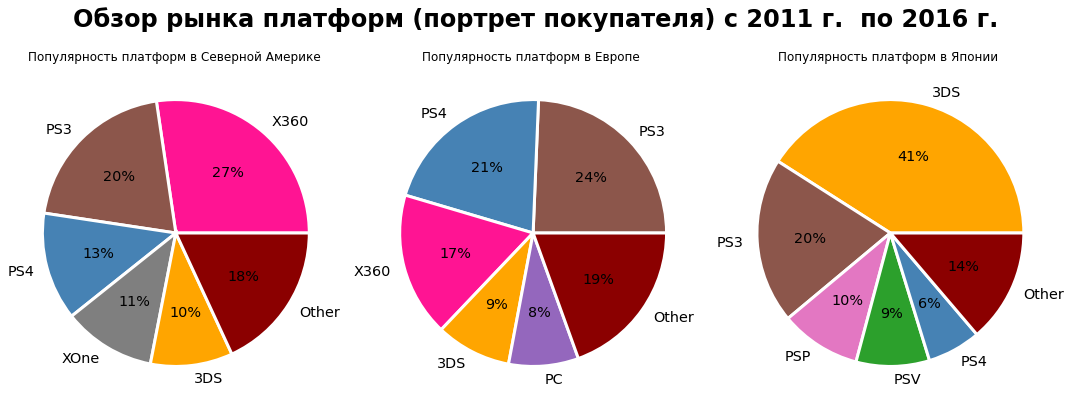

In [37]:
# check
# круги в ряд

x_year = 2011

fig, axes = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle(f'Обзор рынка платформ (портрет покупателя) с {x_year} г.  по 2016 г.', fontsize = 24, fontweight='bold')

graph(data_games, x_year, 'na_sales', 'Северной Америке', axes[0])
graph(data_games, x_year,'eu_sales', 'Европе', axes[1])
graph(data_games, x_year, 'jp_sales', 'Японии', axes[2])

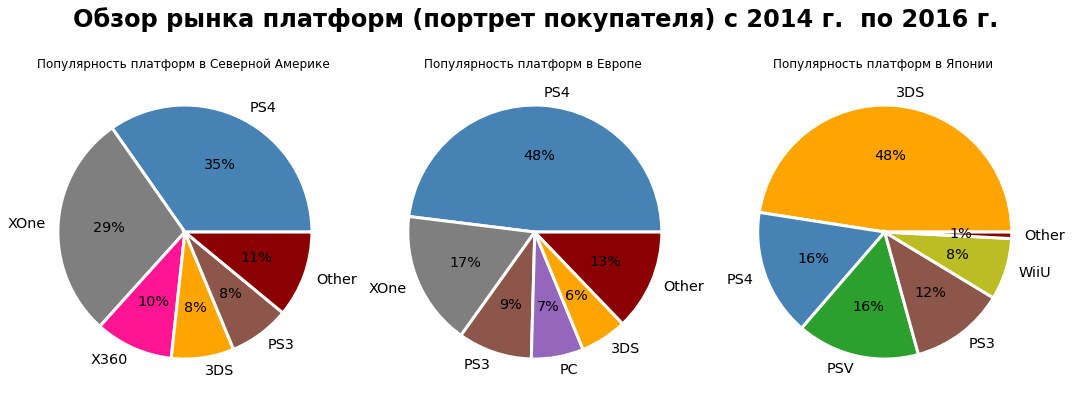

In [38]:
# check
# круги в ряд

x_year = 2014

fig, axes = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle(f'Обзор рынка платформ (портрет покупателя) с {x_year} г.  по 2016 г.', fontsize = 24, fontweight='bold')

graph(data_games, x_year, 'na_sales', 'Северной Америке', axes[0])
graph(data_games, x_year,'eu_sales', 'Европе', axes[1])
graph(data_games, x_year, 'jp_sales', 'Японии', axes[2])

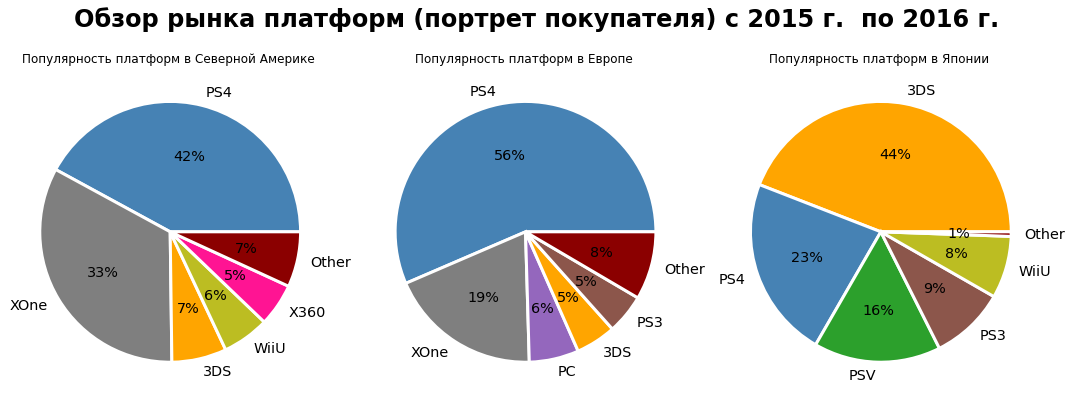

In [39]:
# check
# круги в ряд

x_year = 2015

fig, axes = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle(f'Обзор рынка платформ (портрет покупателя) с {x_year} г.  по 2016 г.', fontsize = 24, fontweight='bold')

graph(data_games, x_year, 'na_sales', 'Северной Америке', axes[0])
graph(data_games, x_year,'eu_sales', 'Европе', axes[1])
graph(data_games, x_year, 'jp_sales', 'Японии', axes[2])